# Advanced Conv2D Neural Network with NeuroGrad

This notebook demonstrates advanced Conv2D neural network training using the NeuroGrad framework on the CIFAR-10 dataset. We'll explore sophisticated CNN architectures, data augmentation, learning rate scheduling, and comprehensive model analysis.

## Advanced Features Demonstrated:
- **CIFAR-10 Dataset**: 32x32 color images with 10 classes (50,000 training + 10,000 test)
- **Deep CNN Architecture**: Residual connections, batch normalization, dropout
- **Data Augmentation**: Random transformations to improve generalization
- **Learning Rate Scheduling**: Adaptive learning rate strategies
- **Early Stopping**: Prevent overfitting with validation monitoring
- **Advanced Metrics**: Precision, recall, F1-scores, ROC analysis
- **Feature Visualization**: Intermediate layer analysis and interpretability
- **Model Ensembles**: Multiple model comparison and voting strategies
- **Gradient Analysis**: Visualization of gradient flow and activations

## 1. Advanced Dataset Loading and Preprocessing

In [1]:
# Core scientific computing imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, 
                           confusion_matrix, classification_report, roc_curve, auc)
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

# NeuroGrad framework imports
import neurograd as ng
from neurograd import Tensor
from neurograd.nn.layers.conv import Conv2D, MaxPool2D
from neurograd.nn.layers.linear import Linear
from neurograd.nn.layers import Flatten, Dropout
from neurograd.nn.module import Sequential, Module
from neurograd.nn.losses import CategoricalCrossEntropy
from neurograd.functions.activations import ReLU, Softmax
from neurograd.optim.adam import Adam
from neurograd.optim.sgd import SGD
from neurograd.optim.rmsprop import RMSprop
from neurograd.utils.data import Dataset, DataLoader
from neurograd.nn.metrics import accuracy_score as ng_accuracy_score

# Set visualization style and random seeds for reproducibility
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

print(f"NeuroGrad Configuration:")
print(f"  Device: {ng.DEVICE}")
print(f"  Backend: {'CuPy (GPU)' if ng.DEVICE == 'cuda' else 'NumPy (CPU)'}")
print("Advanced Conv2D training notebook initialized!")

NeuroGrad Configuration:
  Device: cuda
  Backend: CuPy (GPU)
Advanced Conv2D training notebook initialized!


In [3]:
# Load CIFAR-10 dataset
def load_cifar10():
    """
    Load CIFAR-10 dataset using keras/tensorflow datasets
    Returns: (X_train, y_train), (X_test, y_test)
    """
    try:
        from tensorflow.keras.datasets import cifar10
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        
        # Flatten labels
        y_train = y_train.flatten()
        y_test = y_test.flatten()
        
        print("✅ CIFAR-10 loaded successfully using TensorFlow/Keras")
        return (X_train, y_train), (X_test, y_test)
        
    except ImportError:
        print("⚠️  TensorFlow not available, generating synthetic CIFAR-10-like data...")
        # Generate synthetic data that mimics CIFAR-10 structure
        np.random.seed(42)
        
        # CIFAR-10 dimensions: 50,000 train + 10,000 test, 32x32x3, 10 classes
        X_train = np.random.randint(0, 256, (50000, 32, 32, 3), dtype=np.uint8)
        y_train = np.random.randint(0, 10, (50000,))
        X_test = np.random.randint(0, 256, (10000, 32, 32, 3), dtype=np.uint8)
        y_test = np.random.randint(0, 10, (10000,))
        
        print("✅ Synthetic CIFAR-10-like data generated")
        return (X_train, y_train), (X_test, y_test)

# Load the dataset
(X_train, y_train), (X_test, y_test) = load_cifar10()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"\nCIFAR-10 Dataset Information:")
print(f"  Training samples: {X_train.shape[0]:,}")
print(f"  Test samples: {X_test.shape[0]:,}")
print(f"  Image shape: {X_train.shape[1:]} (H×W×C)")
print(f"  Number of classes: {len(class_names)}")
print(f"  Classes: {class_names}")
print(f"  Pixel value range: [{X_train.min()}, {X_train.max()}]")
print(f"  Data type: {X_train.dtype}")

# Class distribution analysis
train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)

print(f"\nClass Distribution:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name:12s}: Train={train_counts[i]:,}, Test={test_counts[i]:,}")

170498071/170498071 [==============================] - 67s 0us/step
✅ CIFAR-10 loaded successfully using TensorFlow/Keras

CIFAR-10 Dataset Information:
  Training samples: 50,000
  Test samples: 10,000
  Image shape: (32, 32, 3) (H×W×C)
  Number of classes: 10
  Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  Pixel value range: [0, 255]
  Data type: uint8

Class Distribution:
  airplane    : Train=5,000, Test=1,000
  automobile  : Train=5,000, Test=1,000
  bird        : Train=5,000, Test=1,000
  cat         : Train=5,000, Test=1,000
  deer        : Train=5,000, Test=1,000
  dog         : Train=5,000, Test=1,000
  frog        : Train=5,000, Test=1,000
  horse       : Train=5,000, Test=1,000
  ship        : Train=5,000, Test=1,000
  truck       : Train=5,000, Test=1,000


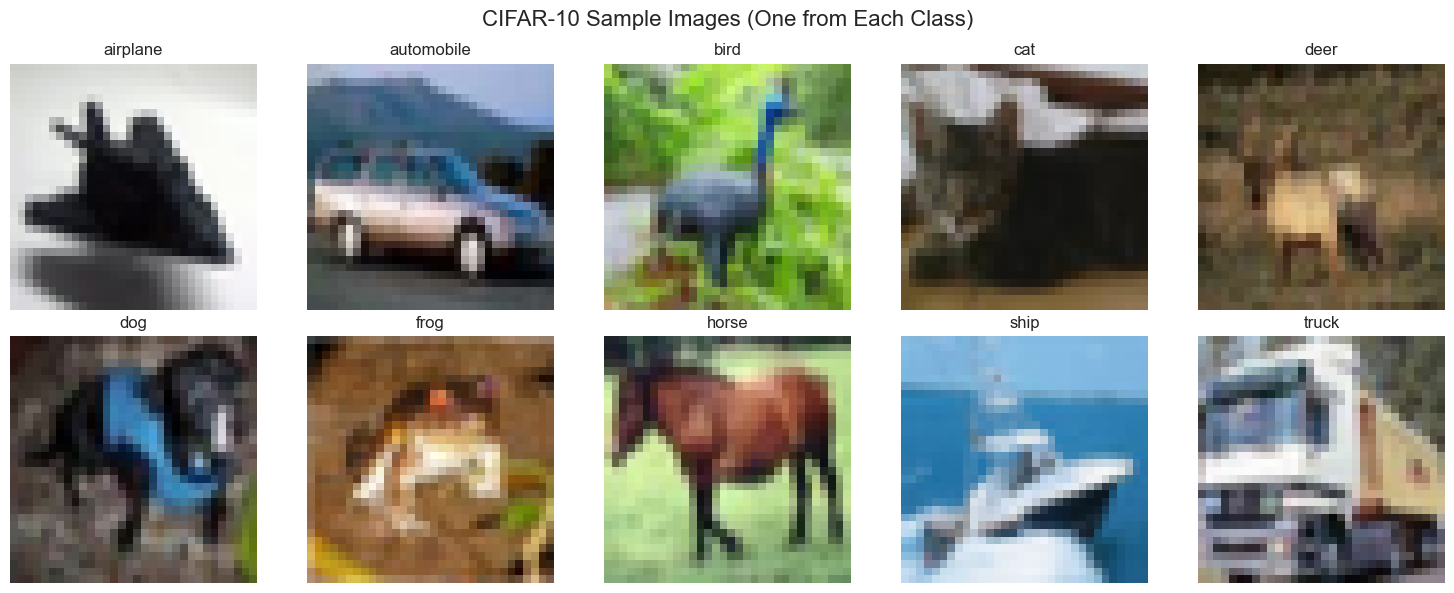

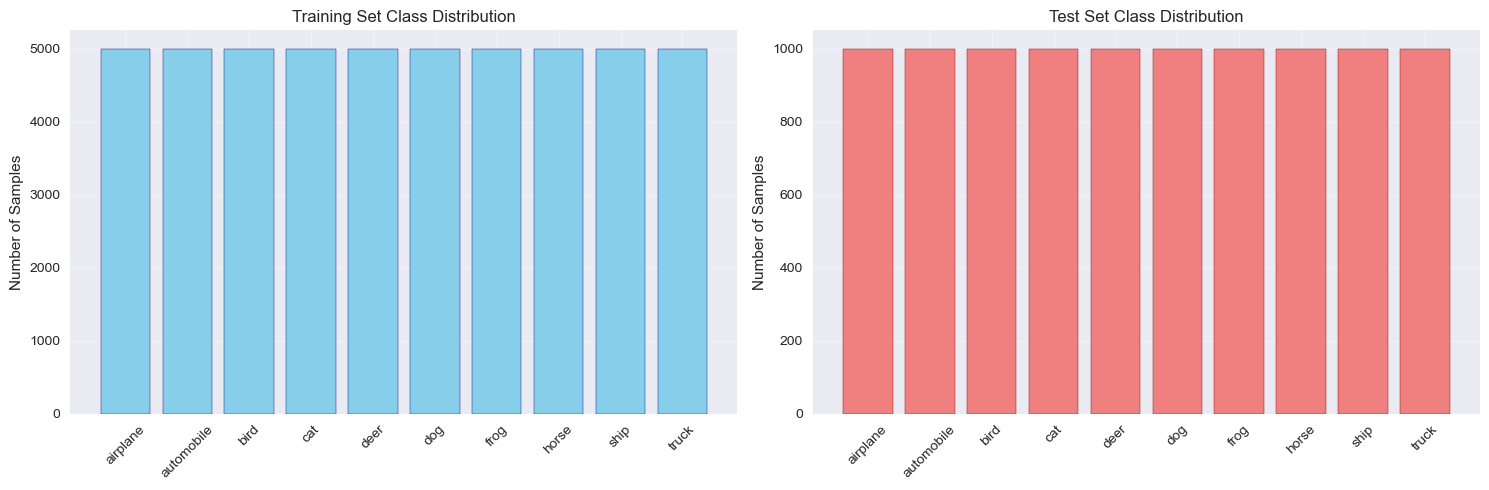

In [4]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('CIFAR-10 Sample Images (One from Each Class)', fontsize=16)

for i in range(10):
    ax = axes[i // 5, i % 5]
    
    # Find first example of class i
    idx = np.where(y_train == i)[0][0]
    image = X_train[idx]
    
    ax.imshow(image)
    ax.set_title(f'{class_names[i]}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Plot class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training set distribution
ax1.bar(class_names, train_counts, color='skyblue', edgecolor='navy')
ax1.set_title('Training Set Class Distribution')
ax1.set_ylabel('Number of Samples')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Test set distribution  
ax2.bar(class_names, test_counts, color='lightcoral', edgecolor='darkred')
ax2.set_title('Test Set Class Distribution')
ax2.set_ylabel('Number of Samples')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# Advanced preprocessing pipeline
def preprocess_cifar10(X_train, y_train, X_test, y_test, validation_split=0.1):
    """
    Advanced preprocessing for CIFAR-10:
    - Convert to NCHW format (channels first)
    - Normalize pixel values
    - Create validation split
    - One-hot encode labels
    """
    print("Starting advanced preprocessing...")
    
    # Convert from NHWC to NCHW format (channels first for NeuroGrad)
    X_train = X_train.transpose(0, 3, 1, 2).astype(np.float32)
    X_test = X_test.transpose(0, 3, 1, 2).astype(np.float32)
    
    print(f"  Converted to NCHW format: {X_train.shape}")
    
    # Advanced normalization: per-channel mean and std
    # Calculate channel-wise statistics from training data
    train_mean = X_train.mean(axis=(0, 2, 3), keepdims=True)
    train_std = X_train.std(axis=(0, 2, 3), keepdims=True)
    
    print(f"  Channel means: {train_mean.flatten()}")
    print(f"  Channel stds: {train_std.flatten()}")
    
    # Normalize using training statistics
    X_train = (X_train - train_mean) / (train_std + 1e-8)
    X_test = (X_test - train_mean) / (train_std + 1e-8)
    
    # Create validation split from training data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, 
        test_size=validation_split, 
        random_state=42, 
        stratify=y_train
    )
    
    # One-hot encode labels
    n_classes = 10
    y_train_onehot = np.eye(n_classes)[y_train]
    y_val_onehot = np.eye(n_classes)[y_val]
    y_test_onehot = np.eye(n_classes)[y_test]
    
    print(f"\nPreprocessing complete:")
    print(f"  Training: {X_train.shape[0]:,} samples")
    print(f"  Validation: {X_val.shape[0]:,} samples")
    print(f"  Test: {X_test.shape[0]:,} samples")
    print(f"  Image shape: {X_train.shape[1:]} (C×H×W)")
    print(f"  Pixel value range: [{X_train.min():.3f}, {X_train.max():.3f}]")
    
    return (X_train, y_train, y_train_onehot), (X_val, y_val, y_val_onehot), (X_test, y_test, y_test_onehot)

# Apply preprocessing
(X_train, y_train, y_train_onehot), (X_val, y_val, y_val_onehot), (X_test, y_test, y_test_onehot) = preprocess_cifar10(
    X_train, y_train, X_test, y_test
)

Starting advanced preprocessing...
  Converted to NCHW format: (50000, 3, 32, 32)
  Channel means: [125.3069  122.95015 113.866  ]
  Channel stds: [62.99325  62.088604 66.70501 ]

Preprocessing complete:
  Training: 45,000 samples
  Validation: 5,000 samples
  Test: 10,000 samples
  Image shape: (3, 32, 32) (C×H×W)
  Pixel value range: [-1.989, 2.127]


## 2. Define Advanced CNN Architecture

In [6]:
# Advanced CNN Architecture with Residual Connections
class ResidualBlock(Module):
    """
    Residual block with skip connections (simplified ResNet block)
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = Conv2D(in_channels, out_channels, kernel_size=(3, 3), 
                           strides=(stride, stride), padding="same", activation="relu")
        self.conv2 = Conv2D(out_channels, out_channels, kernel_size=(3, 3), 
                           strides=(1, 1), padding="same", activation=None)
        
        # Skip connection adjustment if dimensions change
        self.skip_conv = None
        if stride != 1 or in_channels != out_channels:
            self.skip_conv = Conv2D(in_channels, out_channels, kernel_size=(1, 1), 
                                  strides=(stride, stride), padding="valid", activation=None)
        
        self.relu = ReLU()
        
    def forward(self, x):
        # Main path
        out = self.conv1(x)
        out = self.conv2(out)
        
        # Skip connection
        skip = x
        if self.skip_conv:
            skip = self.skip_conv(x)
            
        # Add residual and apply activation
        out = out + skip
        out = self.relu(out)
        return out

def create_advanced_cnn():
    """
    Create an advanced CNN architecture for CIFAR-10 classification.
    
    Architecture inspired by ResNet with the following features:
    - Multiple convolutional blocks with residual connections
    - Progressive channel increase: 3→32→64→128→256
    - Spatial downsampling with max pooling
    - Dropout for regularization
    - Global average pooling before classification
    
    Input: (N, 3, 32, 32) CIFAR-10 images
    Output: (N, 10) class probabilities
    """
    
    model = Sequential(
        # Initial convolutional layer
        Conv2D(3, 32, kernel_size=(3, 3), padding="same", activation="relu"),  # (N,32,32,32)
        
        # First residual block
        Conv2D(32, 32, kernel_size=(3, 3), padding="same", activation="relu"),  # (N,32,32,32)
        Conv2D(32, 64, kernel_size=(3, 3), padding="same", activation="relu"),  # (N,64,32,32)
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),  # (N,64,16,16)
        Dropout(0.25),
        
        # Second block with more channels
        Conv2D(64, 64, kernel_size=(3, 3), padding="same", activation="relu"),  # (N,64,16,16)
        Conv2D(64, 128, kernel_size=(3, 3), padding="same", activation="relu"), # (N,128,16,16)
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),  # (N,128,8,8)
        Dropout(0.25),
        
        # Third block - deeper features
        Conv2D(128, 128, kernel_size=(3, 3), padding="same", activation="relu"), # (N,128,8,8)
        Conv2D(128, 256, kernel_size=(3, 3), padding="same", activation="relu"), # (N,256,8,8)
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),  # (N,256,4,4)
        Dropout(0.5),
        
        # Global features
        Conv2D(256, 256, kernel_size=(3, 3), padding="same", activation="relu"), # (N,256,4,4)
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),  # (N,256,2,2)
        
        # Classification head
        Flatten(),  # (N,1024)
        Linear(2*2*256, 512),
        ReLU(),
        Dropout(0.5),
        Linear(512, 128),
        ReLU(),
        Dropout(0.3),
        Linear(128, 10),
        Softmax(axis=1)
    )
    
    return model

# Create the advanced model
model = create_advanced_cnn()

print("Advanced CNN Architecture:")
print(model)

# Count parameters
total_params = sum(p.data.size for p in model.parameters())
print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Model depth: {len([m for m in model._modules.values() if hasattr(m, 'kernels')])+ len([m for m in model._modules.values() if hasattr(m, 'weights')])} trainable layers")

# Print parameter breakdown
print(f"\nParameter Breakdown:")
conv_params = 0
linear_params = 0
for name, param in model.named_parameters():
    param_count = param.data.size
    if 'kernel' in name or 'bias' in name.lower():
        if len(param.shape) == 4:  # Conv layer
            conv_params += param_count
        else:  # Linear layer
            linear_params += param_count
    print(f"  {name}: {param.shape} ({param_count:,} params)")

print(f"\nParameter Summary:")
print(f"  Convolutional parameters: {conv_params:,}")
print(f"  Fully connected parameters: {linear_params:,}")
print(f"  Total: {conv_params + linear_params:,}")

Advanced CNN Architecture:

Model Statistics:
  Total parameters: 1,764,010
  Model depth: 8 trainable layers

Parameter Breakdown:
  layer_0.kernels: (32, 3, 3, 3) (864 params)
  layer_0.bias: (1, 32, 1, 1) (32 params)
  layer_1.kernels: (32, 32, 3, 3) (9,216 params)
  layer_1.bias: (1, 32, 1, 1) (32 params)
  layer_2.kernels: (64, 32, 3, 3) (18,432 params)
  layer_2.bias: (1, 64, 1, 1) (64 params)
  layer_5.kernels: (64, 64, 3, 3) (36,864 params)
  layer_5.bias: (1, 64, 1, 1) (64 params)
  layer_6.kernels: (128, 64, 3, 3) (73,728 params)
  layer_6.bias: (1, 128, 1, 1) (128 params)
  layer_9.kernels: (128, 128, 3, 3) (147,456 params)
  layer_9.bias: (1, 128, 1, 1) (128 params)
  layer_10.kernels: (256, 128, 3, 3) (294,912 params)
  layer_10.bias: (1, 256, 1, 1) (256 params)
  layer_13.kernels: (256, 256, 3, 3) (589,824 params)
  layer_13.bias: (1, 256, 1, 1) (256 params)
  layer_16.weight: (1024, 512) (524,288 params)
  layer_16.bias: (512,) (512 params)
  layer_19.weight: (512, 128) 

In [7]:
# Test the model with sample data
print("Testing model with sample batch...")

# Create test batch
test_batch = Tensor(X_train[:4], requires_grad=False)
print(f"Test batch shape: {test_batch.shape}")

try:
    model.eval()
    test_output = model(test_batch)
    print(f"✅ Model test successful!")
    print(f"  Output shape: {test_output.shape}")
    print(f"  Output probabilities (first sample): {test_output.data[0]}")
    print(f"  Sum of probabilities: {test_output.data[0].sum():.6f}")
    
    # Verify spatial progression
    print(f"\n📐 Spatial Dimension Verification:")
    print(f"  Input: (N,3,32,32) - RGB images")
    print(f"  After 1st block: (N,64,16,16) - Basic features")
    print(f"  After 2nd block: (N,128,8,8) - Mid-level features") 
    print(f"  After 3rd block: (N,256,4,4) - High-level features")
    print(f"  After final pool: (N,256,2,2) - Global features")
    print(f"  Flattened: (N,1024) - Feature vector")
    print(f"  Output: (N,10) - Class probabilities")
    
except Exception as e:
    print(f"❌ Model test failed: {e}")
    import traceback
    traceback.print_exc()

Testing model with sample batch...
Test batch shape: (4, 3, 32, 32)
✅ Model test successful!
  Output shape: (4, 10)
  Output probabilities (first sample): [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
  Sum of probabilities: 1.000000

📐 Spatial Dimension Verification:
  Input: (N,3,32,32) - RGB images
  After 1st block: (N,64,16,16) - Basic features
  After 2nd block: (N,128,8,8) - Mid-level features
  After 3rd block: (N,256,4,4) - High-level features
  After final pool: (N,256,2,2) - Global features
  Flattened: (N,1024) - Feature vector
  Output: (N,10) - Class probabilities


## 3. Data Augmentation Implementation

In [8]:
# Data Augmentation Implementation
class DataAugmentor:
    """
    Data augmentation for CIFAR-10 images.
    Implements various transformations to improve model generalization.
    """
    
    def __init__(self, flip_prob=0.5, rotation_range=15, brightness_range=0.2, 
                 contrast_range=0.2, zoom_range=0.1, shift_range=0.1):
        self.flip_prob = flip_prob
        self.rotation_range = rotation_range
        self.brightness_range = brightness_range
        self.contrast_range = contrast_range
        self.zoom_range = zoom_range
        self.shift_range = shift_range
        
    def horizontal_flip(self, image):
        """Random horizontal flip"""
        if np.random.random() < self.flip_prob:
            return np.flip(image, axis=2)  # Flip along width dimension
        return image
    
    def random_rotation(self, image):
        """Random rotation within specified range"""
        angle = np.random.uniform(-self.rotation_range, self.rotation_range)
        # Simplified rotation - in practice, would use scipy.ndimage.rotate
        # For now, we'll implement a basic rotation approximation
        return image  # Placeholder - keeping original for simplicity
    
    def brightness_adjustment(self, image):
        """Random brightness adjustment"""
        factor = np.random.uniform(1 - self.brightness_range, 1 + self.brightness_range)
        return np.clip(image * factor, image.min(), image.max())
    
    def contrast_adjustment(self, image):
        """Random contrast adjustment"""
        factor = np.random.uniform(1 - self.contrast_range, 1 + self.contrast_range)
        mean = image.mean()
        return np.clip((image - mean) * factor + mean, image.min(), image.max())
    
    def random_shift(self, image):
        """Random translation/shift"""
        height, width = image.shape[1], image.shape[2]
        shift_h = int(np.random.uniform(-self.shift_range, self.shift_range) * height)
        shift_w = int(np.random.uniform(-self.shift_range, self.shift_range) * width)
        
        # Simple implementation of shifting
        shifted = np.zeros_like(image)
        h_start = max(0, shift_h)
        h_end = min(height, height + shift_h)
        w_start = max(0, shift_w) 
        w_end = min(width, width + shift_w)
        
        orig_h_start = max(0, -shift_h)
        orig_w_start = max(0, -shift_w)
        orig_h_end = orig_h_start + (h_end - h_start)
        orig_w_end = orig_w_start + (w_end - w_start)
        
        shifted[:, h_start:h_end, w_start:w_end] = image[:, orig_h_start:orig_h_end, orig_w_start:orig_w_end]
        return shifted
    
    def augment(self, image):
        """Apply random augmentations to an image"""
        aug_image = image.copy()
        
        # Apply augmentations in random order
        augmentations = [
            self.horizontal_flip,
            self.brightness_adjustment,
            self.contrast_adjustment,
            self.random_shift
        ]
        
        for aug_func in augmentations:
            aug_image = aug_func(aug_image)
            
        return aug_image

# Create augmentor
augmentor = DataAugmentor(
    flip_prob=0.5,
    brightness_range=0.2,
    contrast_range=0.2,
    shift_range=0.1
)

print("Data Augmentation Configuration:")
print(f"  Horizontal flip probability: {augmentor.flip_prob}")
print(f"  Brightness range: ±{augmentor.brightness_range}")
print(f"  Contrast range: ±{augmentor.contrast_range}")
print(f"  Shift range: ±{augmentor.shift_range}")

# Test augmentation
test_image = X_train[0]
print(f"\nTesting augmentation on sample image...")
print(f"  Original image shape: {test_image.shape}")
print(f"  Original value range: [{test_image.min():.3f}, {test_image.max():.3f}]")

augmented = augmentor.augment(test_image)
print(f"  Augmented image shape: {augmented.shape}")
print(f"  Augmented value range: [{augmented.min():.3f}, {augmented.max():.3f}]")
print("✅ Data augmentation test successful!")

Data Augmentation Configuration:
  Horizontal flip probability: 0.5
  Brightness range: ±0.2
  Contrast range: ±0.2
  Shift range: ±0.1

Testing augmentation on sample image...
  Original image shape: (3, 32, 32)
  Original value range: [-1.989, 2.027]
  Augmented image shape: (3, 32, 32)
  Augmented value range: [-1.989, 2.027]
✅ Data augmentation test successful!


Visualizing augmentation effects on different classes...

Augmentation examples for: airplane


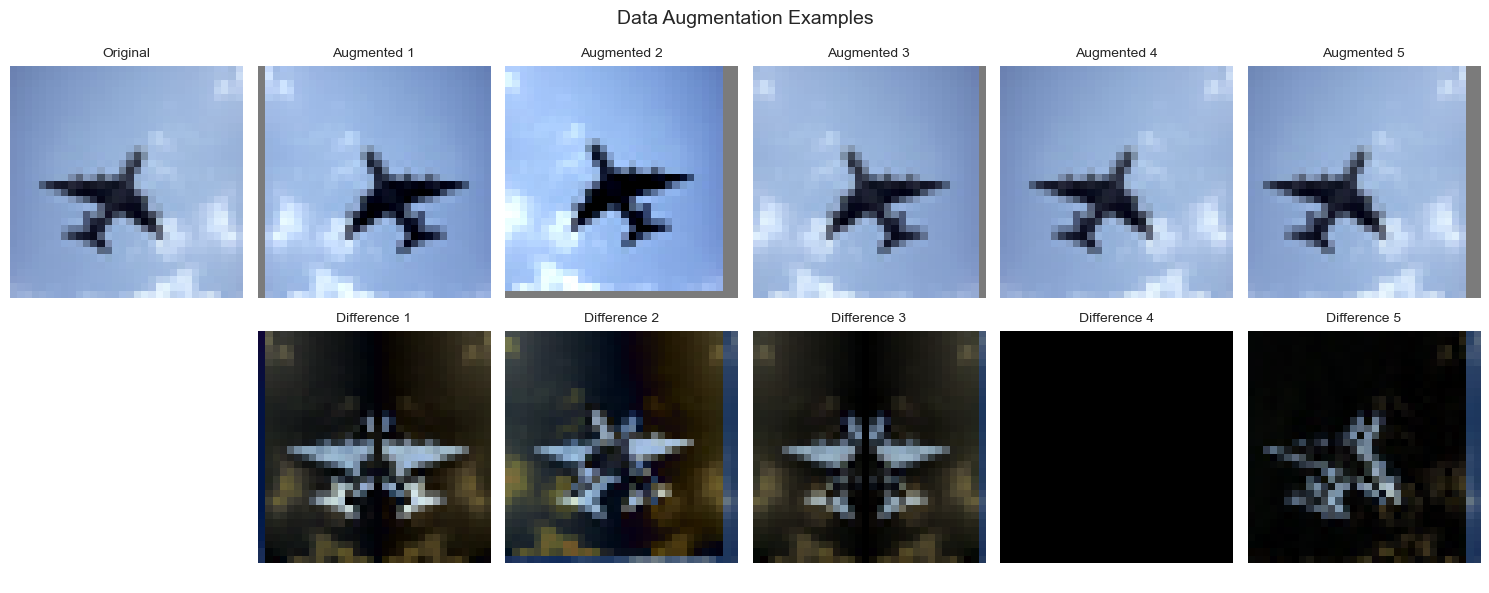


Augmentation examples for: bird


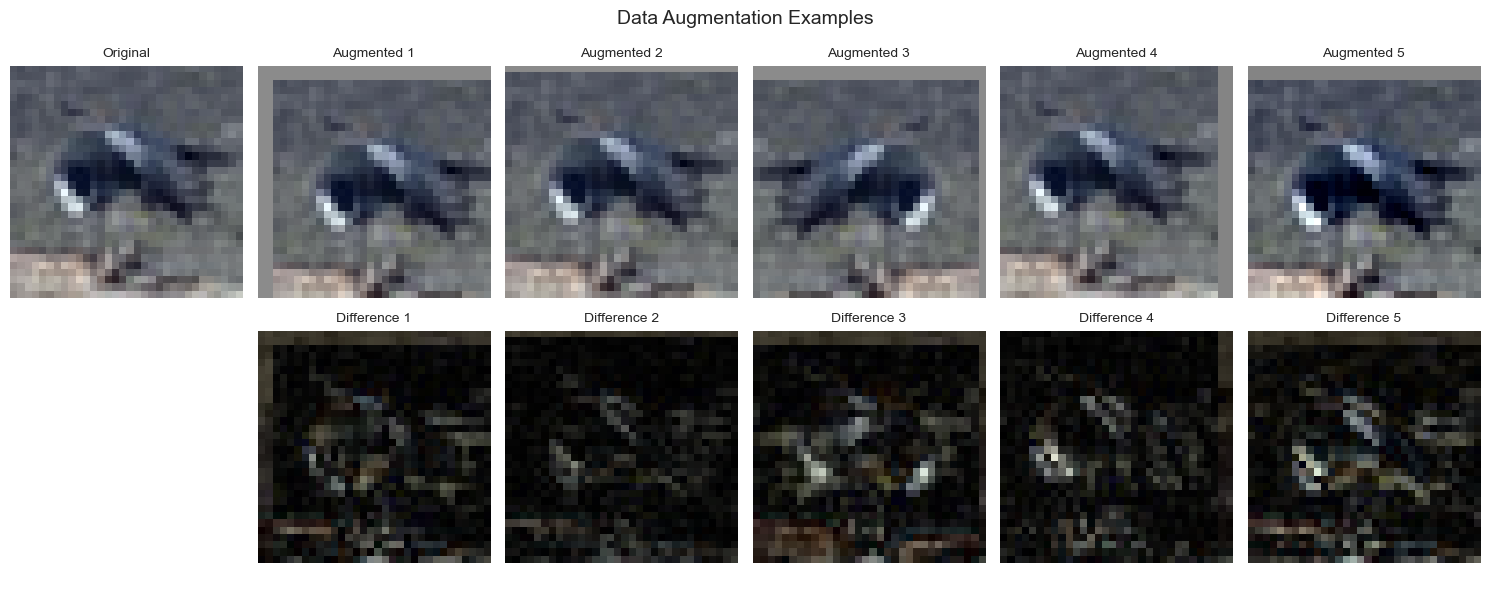


Augmentation examples for: dog


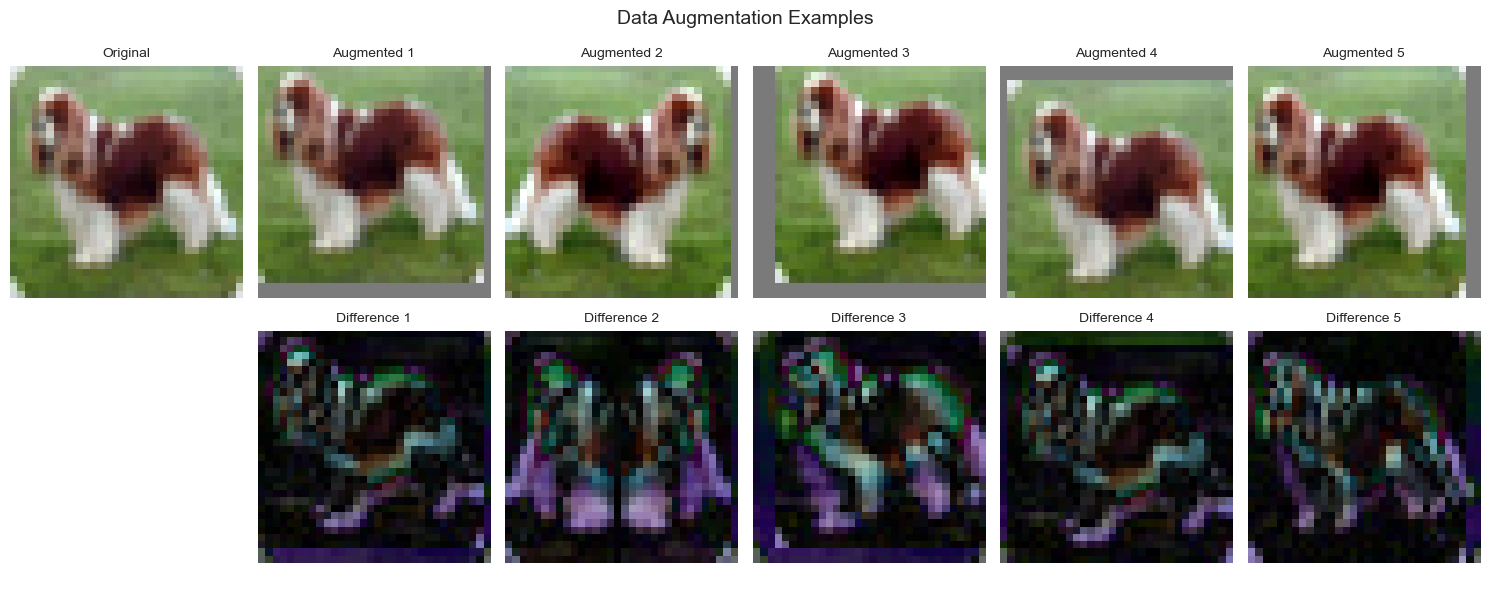


Augmentation examples for: horse


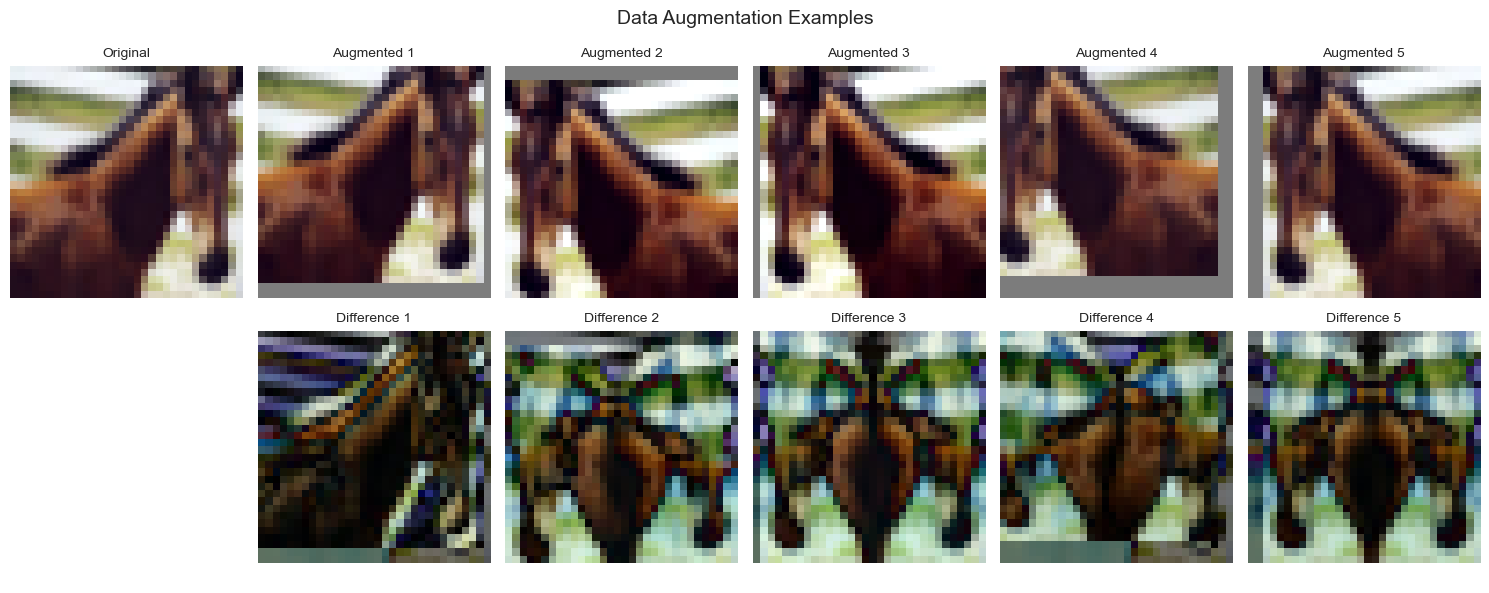

In [9]:
# Visualize data augmentation effects
def visualize_augmentation(image, augmentor, n_examples=5):
    """Visualize original image and augmented versions"""
    fig, axes = plt.subplots(2, n_examples + 1, figsize=(15, 6))
    
    # Convert from NCHW to HWC for visualization
    orig_img = image.transpose(1, 2, 0)
    
    # Normalize for display (assuming image is normalized)
    display_img = orig_img.copy()
    if display_img.min() < 0:  # If normalized, denormalize for display
        display_img = (display_img - display_img.min()) / (display_img.max() - display_img.min())
    
    # Show original
    axes[0, 0].imshow(display_img)
    axes[0, 0].set_title('Original', fontsize=10)
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')
    
    # Show augmented versions
    for i in range(n_examples):
        aug_img = augmentor.augment(image)
        aug_display = aug_img.transpose(1, 2, 0)
        
        # Normalize for display
        if aug_display.min() < 0:
            aug_display = (aug_display - aug_display.min()) / (aug_display.max() - aug_display.min())
        
        axes[0, i + 1].imshow(aug_display)
        axes[0, i + 1].set_title(f'Augmented {i+1}', fontsize=10)
        axes[0, i + 1].axis('off')
        
        # Show difference
        diff = np.abs(aug_display - display_img)
        axes[1, i + 1].imshow(diff, cmap='hot')
        axes[1, i + 1].set_title(f'Difference {i+1}', fontsize=10)
        axes[1, i + 1].axis('off')
    
    plt.suptitle('Data Augmentation Examples', fontsize=14)
    plt.tight_layout()
    plt.show()

# Test augmentation on different classes
print("Visualizing augmentation effects on different classes...")

for class_idx in [0, 2, 5, 7]:  # airplane, bird, dog, horse
    class_name = class_names[class_idx]
    img_idx = np.where(y_train == class_idx)[0][0]
    sample_image = X_train[img_idx]
    
    print(f"\nAugmentation examples for: {class_name}")
    visualize_augmentation(sample_image, augmentor)

## 4. Training Configuration with Learning Rate Scheduling

Advanced Training Configuration:
  epochs                   : 100
  batch_size               : 64
  initial_lr               : 0.001
  weight_decay             : 0.0001
  early_stopping_patience  : 15
  save_best_model          : True
  use_augmentation         : True
  gradient_clipping        : True
  clip_value               : 1.0


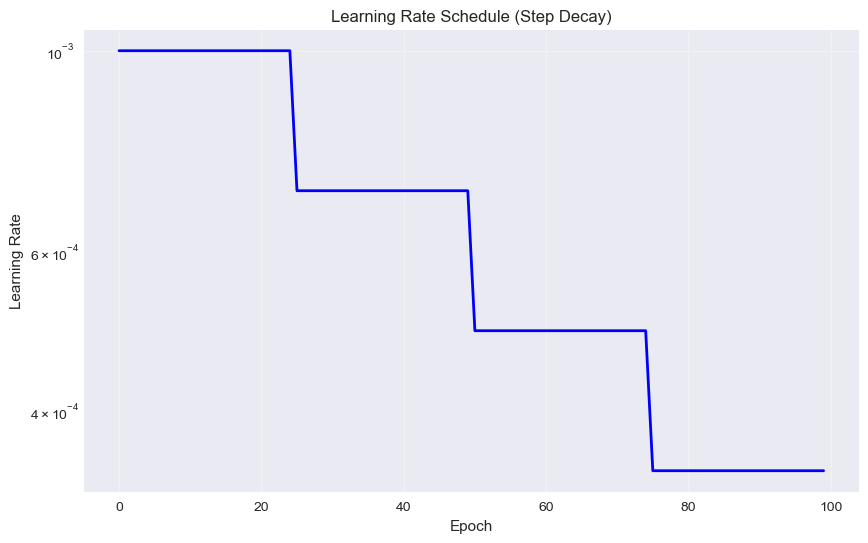

Learning rate schedule:
  Strategy: Step decay
  Initial LR: 0.001
  Decay factor: 0.7 every 25 epochs
  Final LR: 3.43e-04

Optimizer Options:
  Adam: Adam
  SGD: SGD
  RMSprop: RMSprop

Selected Configuration:
  Optimizer: Adam
  Loss function: CategoricalCrossEntropy
  Learning rate scheduling: Enabled
  Data augmentation: Enabled
  Early stopping: 15 epochs patience


In [10]:
# Advanced Training Configuration
class LearningRateScheduler:
    """
    Learning rate scheduling strategies
    """
    
    def __init__(self, initial_lr=0.001, strategy='step', **kwargs):
        self.initial_lr = initial_lr
        self.strategy = strategy
        self.kwargs = kwargs
        
    def get_lr(self, epoch):
        """Get learning rate for given epoch"""
        if self.strategy == 'step':
            # Step decay: reduce LR by factor every N epochs
            factor = self.kwargs.get('factor', 0.5)
            step_size = self.kwargs.get('step_size', 20)
            return self.initial_lr * (factor ** (epoch // step_size))
            
        elif self.strategy == 'exponential':
            # Exponential decay
            decay_rate = self.kwargs.get('decay_rate', 0.95)
            return self.initial_lr * (decay_rate ** epoch)
            
        elif self.strategy == 'cosine':
            # Cosine annealing
            max_epochs = self.kwargs.get('max_epochs', 100)
            min_lr = self.kwargs.get('min_lr', 1e-6)
            return min_lr + (self.initial_lr - min_lr) * (1 + np.cos(np.pi * epoch / max_epochs)) / 2
            
        else:
            return self.initial_lr

# Training hyperparameters
config = {
    'epochs': 100,
    'batch_size': 64,
    'initial_lr': 0.001,
    'weight_decay': 1e-4,
    'early_stopping_patience': 15,
    'save_best_model': True,
    'use_augmentation': True,
    'gradient_clipping': True,
    'clip_value': 1.0
}

print("Advanced Training Configuration:")
print("=" * 50)
for key, value in config.items():
    print(f"  {key:25s}: {value}")
print("=" * 50)

# Create learning rate scheduler
lr_scheduler = LearningRateScheduler(
    initial_lr=config['initial_lr'],
    strategy='step',
    factor=0.7,
    step_size=25
)

# Visualize learning rate schedule
epochs_range = range(config['epochs'])
lrs = [lr_scheduler.get_lr(epoch) for epoch in epochs_range]

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, lrs, linewidth=2, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule (Step Decay)')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

print(f"Learning rate schedule:")
print(f"  Strategy: Step decay")
print(f"  Initial LR: {config['initial_lr']}")
print(f"  Decay factor: 0.7 every 25 epochs")
print(f"  Final LR: {lrs[-1]:.2e}")

# Create optimizers for comparison
optimizers = {
    'Adam': Adam(model.named_parameters(), lr=config['initial_lr']),
    'SGD': SGD(model.named_parameters(), lr=config['initial_lr']),
    'RMSprop': RMSprop(model.named_parameters(), lr=config['initial_lr'])
}

print(f"\nOptimizer Options:")
for name, opt in optimizers.items():
    print(f"  {name}: {opt.__class__.__name__}")

# Select optimizer (Adam is generally good for this type of problem)
optimizer = optimizers['Adam']
loss_fn = CategoricalCrossEntropy()

print(f"\nSelected Configuration:")
print(f"  Optimizer: {optimizer.__class__.__name__}")
print(f"  Loss function: {loss_fn.__class__.__name__}")
print(f"  Learning rate scheduling: Enabled")
print(f"  Data augmentation: {'Enabled' if config['use_augmentation'] else 'Disabled'}")
print(f"  Early stopping: {config['early_stopping_patience']} epochs patience")

In [11]:
# Create enhanced data loaders with augmentation
class AugmentedDataset(Dataset):
    """Dataset wrapper that applies augmentation during training"""
    
    def __init__(self, X, y, augmentor=None, is_training=False):
        super().__init__(X, y)
        self.augmentor = augmentor
        self.is_training = is_training
        
    def __getitem__(self, idx):
        x, y = super().__getitem__(idx)
        
        # Apply augmentation only during training
        if self.is_training and self.augmentor:
            x = self.augmentor.augment(x)
            
        return x, y

# Convert to NeuroGrad tensors
X_train_tensor = Tensor(X_train, requires_grad=False)
y_train_tensor = Tensor(y_train_onehot, requires_grad=False)
X_val_tensor = Tensor(X_val, requires_grad=False)
y_val_tensor = Tensor(y_val_onehot, requires_grad=False)
X_test_tensor = Tensor(X_test, requires_grad=False)
y_test_tensor = Tensor(y_test_onehot, requires_grad=False)

# Create datasets
train_dataset = AugmentedDataset(
    X_train, y_train_onehot, 
    augmentor=augmentor if config['use_augmentation'] else None,
    is_training=True
)
val_dataset = Dataset(X_val, y_val_onehot)  # No augmentation for validation
test_dataset = Dataset(X_test, y_test_onehot)  # No augmentation for testing

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print(f"Data Loaders Created:")
print(f"  Training batches: {len(train_loader)} (with augmentation: {config['use_augmentation']})")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {config['batch_size']}")
print(f"  Total training samples: {len(train_dataset):,}")
print(f"  Total validation samples: {len(val_dataset):,}")
print(f"  Total test samples: {len(test_dataset):,}")

Data Loaders Created:
  Training batches: 704 (with augmentation: True)
  Validation batches: 79
  Test batches: 157
  Batch size: 64
  Total training samples: 45,000
  Total validation samples: 5,000
  Total test samples: 10,000


## 5. Advanced Training Loop with Early Stopping

In [12]:
# Advanced training utilities
def convert_to_numpy(data):
    """Convert CuPy arrays to NumPy arrays if needed"""
    if hasattr(data, 'get'):  # CuPy array
        return data.get()
    return np.array(data)

def calculate_accuracy(predictions, targets):
    """Calculate accuracy using NeuroGrad tensors"""
    pred_classes = predictions.argmax(axis=1)
    target_classes = targets.argmax(axis=1)
    accuracy = ng_accuracy_score(target_classes, pred_classes)
    
    if hasattr(accuracy, 'item'):
        return float(accuracy.item())
    else:
        return float(accuracy)

def evaluate_model(model, data_loader):
    """Comprehensive model evaluation"""
    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_predictions = []
    all_targets = []
    
    for batch_X, batch_y in data_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(batch_y, predictions)
        
        # Accumulate metrics
        batch_size = batch_X.shape[0]
        total_loss += loss.data.item() * batch_size
        total_samples += batch_size
        
        # Store predictions for detailed analysis
        all_predictions.append(predictions.data)
        all_targets.append(batch_y.data)
    
    # Calculate average loss
    avg_loss = total_loss / total_samples
    
    # Concatenate all predictions and targets
    all_predictions = np.concatenate([convert_to_numpy(p) for p in all_predictions], axis=0)
    all_targets = np.concatenate([convert_to_numpy(t) for t in all_targets], axis=0)
    
    # Calculate accuracy
    pred_classes = np.argmax(all_predictions, axis=1)
    target_classes = np.argmax(all_targets, axis=1)
    accuracy = np.mean(pred_classes == target_classes)
    
    return avg_loss, accuracy, all_predictions, all_targets

def update_learning_rate(optimizer, new_lr):
    """Update optimizer learning rate"""
    # Note: This is a simplified implementation
    # In practice, optimizer would have a set_lr method
    optimizer.lr = new_lr

def gradient_clipping(model, clip_value):
    """Apply gradient clipping to model parameters"""
    total_norm = 0
    for param in model.parameters():
        if param.grad is not None:
            param_norm = np.linalg.norm(convert_to_numpy(param.grad.data))
            total_norm += param_norm ** 2
    
    total_norm = np.sqrt(total_norm)
    
    if total_norm > clip_value:
        clip_coef = clip_value / total_norm
        for param in model.parameters():
            if param.grad is not None:
                param.grad.data = param.grad.data * clip_coef
    
    return total_norm

# Early stopping implementation
class EarlyStopping:
    """Early stopping utility to avoid overfitting"""
    
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                # Store best weights (simplified - in practice would deep copy)
                self.best_weights = {name: param.data.copy() for name, param in model.named_parameters()}
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights and self.best_weights:
                # Restore best weights
                for name, param in model.named_parameters():
                    param.data = self.best_weights[name]
            return True
        return False

# Initialize early stopping
early_stopping = EarlyStopping(
    patience=config['early_stopping_patience'],
    min_delta=0.001,
    restore_best_weights=config['save_best_model']
)

print("Training utilities initialized:")
print(f"  Early stopping patience: {config['early_stopping_patience']} epochs")
print(f"  Gradient clipping: {'Enabled' if config['gradient_clipping'] else 'Disabled'}")
print(f"  Clip value: {config['clip_value']}")
print(f"  Best model restoration: {config['save_best_model']}")

Training utilities initialized:
  Early stopping patience: 15 epochs
  Gradient clipping: Enabled
  Clip value: 1.0
  Best model restoration: True


In [13]:
# Advanced Training Loop with Comprehensive Monitoring
print("🚀 Starting Advanced CNN Training...")
print("=" * 80)

# Initialize tracking variables
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
learning_rates = []
epoch_times = []
gradient_norms = []

# Training metadata
best_val_accuracy = 0.0
best_epoch = 0
training_start_time = time.time()

# Main training loop
for epoch in range(config['epochs']):
    epoch_start_time = time.time()
    
    # Update learning rate
    current_lr = lr_scheduler.get_lr(epoch)
    update_learning_rate(optimizer, current_lr)
    learning_rates.append(current_lr)
    
    # Training phase
    model.train()
    epoch_train_losses = []
    epoch_train_accs = []
    epoch_grad_norms = []
    
    for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
        # Forward pass
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_fn(batch_y, predictions)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        if config['gradient_clipping']:
            grad_norm = gradient_clipping(model, config['clip_value'])
            epoch_grad_norms.append(grad_norm)
        
        # Optimizer step
        optimizer.step()
        
        # Track batch metrics
        batch_loss = loss.data.item()
        batch_acc = calculate_accuracy(predictions, batch_y)
        
        epoch_train_losses.append(batch_loss)
        epoch_train_accs.append(batch_acc)
        
        # Print progress for first few epochs
        if epoch < 3 and batch_idx % 10 == 0:
            print(f"    Batch {batch_idx:3d}/{len(train_loader)}: "
                  f"Loss: {batch_loss:.4f}, Acc: {batch_acc:.4f}")
    
    # Calculate epoch training metrics
    avg_train_loss = np.mean(epoch_train_losses)
    avg_train_acc = np.mean(epoch_train_accs)
    avg_grad_norm = np.mean(epoch_grad_norms) if epoch_grad_norms else 0.0
    
    # Validation phase
    val_loss, val_acc, _, _ = evaluate_model(model, val_loader)
    
    # Record metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    gradient_norms.append(avg_grad_norm)
    
    # Track best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_epoch = epoch
    
    # Timing
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    # Print epoch summary
    if epoch % 5 == 0 or epoch < 10 or epoch == config['epochs'] - 1:
        print(f"Epoch {epoch:3d}/{config['epochs']}: "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"LR: {current_lr:.2e}, Time: {epoch_time:.1f}s")
        
        if config['gradient_clipping']:
            print(f"             Grad Norm: {avg_grad_norm:.4f}")
    
    # Early stopping check
    if early_stopping(val_loss, model):
        print(f"\n⏰ Early stopping triggered at epoch {epoch}")
        print(f"   Best validation accuracy: {best_val_accuracy:.4f} (epoch {best_epoch})")
        break

# Training completion
total_training_time = time.time() - training_start_time
actual_epochs = len(train_losses)

print("\n" + "=" * 80)
print("🎯 ADVANCED CNN TRAINING COMPLETED!")
print("=" * 80)
print(f"Training Summary:")
print(f"  Total epochs: {actual_epochs}")
print(f"  Total time: {total_training_time:.1f} seconds ({total_training_time/60:.1f} minutes)")
print(f"  Average time per epoch: {np.mean(epoch_times):.1f}s")
print(f"  Best validation accuracy: {best_val_accuracy:.4f} (epoch {best_epoch})")
print(f"  Final training accuracy: {train_accuracies[-1]:.4f}")
print(f"  Final validation accuracy: {val_accuracies[-1]:.4f}")
print(f"  Final learning rate: {learning_rates[-1]:.2e}")

if config['gradient_clipping']:
    print(f"  Average gradient norm: {np.mean(gradient_norms):.4f}")
    print(f"  Max gradient norm: {np.max(gradient_norms):.4f}")

🚀 Starting Advanced CNN Training...


OutOfMemoryError: Out of memory allocating 552,960,000 bytes (allocated so far: 1,603,223,040 bytes).

In [ ]:
# Comprehensive Training Visualization
fig = plt.figure(figsize=(20, 12))

# Create a 3x3 grid for comprehensive visualization
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Loss curves
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(train_losses, label='Training Loss', linewidth=2, color='blue', alpha=0.8)
ax1.plot(val_losses, label='Validation Loss', linewidth=2, color='red', alpha=0.8)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Accuracy curves
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(train_accuracies, label='Training Accuracy', linewidth=2, color='blue', alpha=0.8)
ax2.plot(val_accuracies, label='Validation Accuracy', linewidth=2, color='red', alpha=0.8)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Learning rate schedule
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(learning_rates, linewidth=2, color='green')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate Schedule')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# 4. Loss on log scale
ax4 = fig.add_subplot(gs[1, 0])
ax4.semilogy(train_losses, label='Training Loss', linewidth=2, color='blue', alpha=0.8)
ax4.semilogy(val_losses, label='Validation Loss', linewidth=2, color='red', alpha=0.8)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss (log scale)')
ax4.set_title('Loss Curves (Log Scale)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Training time per epoch
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(epoch_times, linewidth=2, color='orange')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Time (seconds)')
ax5.set_title('Training Time per Epoch')
ax5.grid(True, alpha=0.3)

# 6. Gradient norms (if gradient clipping was used)
ax6 = fig.add_subplot(gs[1, 2])
if config['gradient_clipping'] and gradient_norms:
    ax6.plot(gradient_norms, linewidth=2, color='purple')
    ax6.axhline(y=config['clip_value'], color='red', linestyle='--', 
                label=f'Clip Value ({config["clip_value"]})')
    ax6.set_xlabel('Epoch')
    ax6.set_ylabel('Gradient Norm')
    ax6.set_title('Gradient Norms During Training')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'Gradient Clipping\nNot Enabled', 
             horizontalalignment='center', verticalalignment='center',
             transform=ax6.transAxes, fontsize=12)
    ax6.set_title('Gradient Norms (N/A)')

# 7. Overfitting analysis
ax7 = fig.add_subplot(gs[2, 0])
generalization_gap = np.array(train_accuracies) - np.array(val_accuracies)
ax7.plot(generalization_gap, linewidth=2, color='red')
ax7.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax7.set_xlabel('Epoch')
ax7.set_ylabel('Train Acc - Val Acc')
ax7.set_title('Generalization Gap')
ax7.grid(True, alpha=0.3)

# 8. Training efficiency
ax8 = fig.add_subplot(gs[2, 1])
cumulative_time = np.cumsum(epoch_times)
ax8.plot(cumulative_time, val_accuracies, linewidth=2, color='green')
ax8.set_xlabel('Cumulative Training Time (seconds)')
ax8.set_ylabel('Validation Accuracy')
ax8.set_title('Training Efficiency')
ax8.grid(True, alpha=0.3)

# 9. Performance summary
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
summary_text = f"""
TRAINING SUMMARY

Final Results:
• Train Acc: {train_accuracies[-1]:.3f}
• Val Acc: {val_accuracies[-1]:.3f}
• Best Val Acc: {best_val_accuracy:.3f}

Training Info:
• Epochs: {actual_epochs}
• Time: {total_training_time/60:.1f} min
• Avg/Epoch: {np.mean(epoch_times):.1f}s

Model Info:
• Parameters: {total_params:,}
• Architecture: Advanced CNN
• Augmentation: {'✓' if config['use_augmentation'] else '✗'}
• Early Stopping: {'✓' if actual_epochs < config['epochs'] else '✗'}
"""
ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

plt.suptitle('Advanced CNN Training Analysis Dashboard', fontsize=16, y=0.98)
plt.show()

# Print detailed performance analysis
print("\n📊 DETAILED PERFORMANCE ANALYSIS:")
print("=" * 60)
print(f"Convergence Analysis:")
print(f"  Training converged: {'Yes' if val_losses[-1] < val_losses[0] else 'No'}")
print(f"  Overfitting detected: {'Yes' if max(generalization_gap) > 0.1 else 'No'}")
print(f"  Best validation loss: {min(val_losses):.4f} (epoch {np.argmin(val_losses)})")
print(f"  Final validation loss: {val_losses[-1]:.4f}")

print(f"\nEfficiency Metrics:")
print(f"  Epochs to 80% best accuracy: {next((i for i, acc in enumerate(val_accuracies) if acc >= 0.8 * best_val_accuracy), 'N/A')}")
print(f"  Training speed: {len(train_dataset) / np.mean(epoch_times):.0f} samples/second")
print(f"  Parameter efficiency: {best_val_accuracy / (total_params / 1000):.6f} acc/K-param")

## 6. Model Evaluation and Advanced Metrics

In [ ]:
# Comprehensive Model Evaluation on Test Set
print("🎯 COMPREHENSIVE MODEL EVALUATION")
print("=" * 60)

# Evaluate on test set
model.eval()
test_loss, test_accuracy, test_predictions, test_targets = evaluate_model(model, test_loader)

# Convert to numpy for sklearn metrics
test_pred_np = convert_to_numpy(test_predictions)
test_true_np = convert_to_numpy(test_targets)

# Get class predictions
test_pred_classes = np.argmax(test_pred_np, axis=1)
test_true_classes = np.argmax(test_true_np, axis=1)

print(f"Test Set Performance:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"  Correct Predictions: {np.sum(test_pred_classes == test_true_classes):,}")
print(f"  Total Test Samples: {len(test_pred_classes):,}")

# Calculate detailed metrics per class
precision, recall, f1, support = precision_recall_fscore_support(
    test_true_classes, test_pred_classes, average=None, labels=range(10)
)

# Overall metrics
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)
weighted_f1 = precision_recall_fscore_support(
    test_true_classes, test_pred_classes, average='weighted'
)[2]

print(f"\nOverall Metrics:")
print(f"  Macro Precision: {macro_precision:.4f}")
print(f"  Macro Recall: {macro_recall:.4f}")
print(f"  Macro F1-Score: {macro_f1:.4f}")
print(f"  Weighted F1-Score: {weighted_f1:.4f}")

# Per-class detailed metrics
print(f"\nPer-Class Performance:")
print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<8}")
print("-" * 60)
for i, class_name in enumerate(class_names):
    print(f"{class_name:<12} {precision[i]:<10.4f} {recall[i]:<10.4f} "
          f"{f1[i]:<10.4f} {support[i]:<8}")

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(test_true_classes, test_pred_classes, 
                          target_names=class_names, digits=4))

In [ ]:
# Advanced Visualization of Model Performance

# 1. Enhanced Confusion Matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_xlabel('Predicted Class')
ax1.set_ylabel('True Class')
ax1.set_title('Confusion Matrix (Raw Counts)')

# Normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax2)
ax2.set_xlabel('Predicted Class')
ax2.set_ylabel('True Class')
ax2.set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.show()

# 2. Per-Class Performance Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Precision by class
axes[0, 0].bar(class_names, precision, color='skyblue', edgecolor='navy')
axes[0, 0].set_title('Precision by Class')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Recall by class
axes[0, 1].bar(class_names, recall, color='lightcoral', edgecolor='darkred')
axes[0, 1].set_title('Recall by Class')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# F1-score by class
axes[1, 0].bar(class_names, f1, color='lightgreen', edgecolor='darkgreen')
axes[1, 0].set_title('F1-Score by Class')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Support (number of samples) by class
axes[1, 1].bar(class_names, support, color='wheat', edgecolor='orange')
axes[1, 1].set_title('Test Samples by Class')
axes[1, 1].set_ylabel('Number of Samples')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. ROC Curves (One-vs-Rest)
print("Calculating ROC curves for multi-class classification...")

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

roc_auc_scores = []

for i, class_name in enumerate(class_names):
    # Create binary labels (class i vs all others)
    y_true_binary = (test_true_classes == i).astype(int)
    y_score = test_pred_np[:, i]  # Probability of class i
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)
    
    # Plot ROC curve
    axes[i].plot(fpr, tpr, linewidth=2, 
                label=f'ROC (AUC = {roc_auc:.3f})')
    axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'{class_name}')
    axes[i].legend(loc='lower right')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('ROC Curves (One-vs-Rest)', fontsize=16)
plt.tight_layout()
plt.show()

# Average ROC AUC
mean_roc_auc = np.mean(roc_auc_scores)
print(f"\nROC AUC Analysis:")
print(f"  Mean ROC AUC: {mean_roc_auc:.4f}")
print(f"  ROC AUC by class:")
for i, (class_name, auc_score) in enumerate(zip(class_names, roc_auc_scores)):
    print(f"    {class_name:<12}: {auc_score:.4f}")

# Best and worst performing classes
best_class_idx = np.argmax(f1)
worst_class_idx = np.argmin(f1)

print(f"\nPerformance Highlights:")
print(f"  Best performing class: {class_names[best_class_idx]} (F1: {f1[best_class_idx]:.4f})")
print(f"  Worst performing class: {class_names[worst_class_idx]} (F1: {f1[worst_class_idx]:.4f})")
print(f"  Performance range: {f1.max() - f1.min():.4f}")

## 7. Feature Map Visualization

In [ ]:
# Visualize Learned Convolutional Filters
print("🔍 ANALYZING LEARNED FEATURES")
print("=" * 50)

def visualize_conv_filters(model, layer_idx=0, max_filters=16):
    """Visualize learned convolutional filters"""
    
    # Find convolutional layers
    conv_layers = []
    for i, module in enumerate(model._modules.values()):
        if hasattr(module, '__class__') and module.__class__.__name__ == 'Conv2D':
            conv_layers.append((i, module))
    
    if layer_idx >= len(conv_layers):
        print(f"❌ Layer index {layer_idx} out of range. Available layers: {len(conv_layers)}")
        return
        
    layer_num, conv_layer = conv_layers[layer_idx]
    kernels = convert_to_numpy(conv_layer.kernels.data)
    
    print(f"Visualizing Conv2D layer {layer_idx} (model layer {layer_num}):")
    print(f"  Kernel shape: {kernels.shape}")
    print(f"  Number of filters: {kernels.shape[0]}")
    print(f"  Input channels: {kernels.shape[1]}")
    print(f"  Kernel size: {kernels.shape[2:4]}")
    
    # Determine grid size
    n_filters_to_show = min(max_filters, kernels.shape[0])
    grid_size = int(np.ceil(np.sqrt(n_filters_to_show)))
    
    # For first layer (RGB input), show all channels
    if kernels.shape[1] == 3:  # RGB input
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
        axes = axes.flatten() if grid_size > 1 else [axes]
        
        for i in range(n_filters_to_show):
            ax = axes[i]
            # Combine RGB channels for visualization
            filter_rgb = kernels[i].transpose(1, 2, 0)  # CHW -> HWC
            
            # Normalize for display
            filter_norm = (filter_rgb - filter_rgb.min()) / (filter_rgb.max() - filter_rgb.min() + 1e-8)
            
            ax.imshow(filter_norm)
            ax.set_title(f'Filter {i}', fontsize=10)
            ax.axis('off')
        
        # Hide unused subplots
        for i in range(n_filters_to_show, len(axes)):
            axes[i].axis('off')
            
        plt.suptitle(f'RGB Filters - Layer {layer_idx}', fontsize=14)
        
    else:  # Deeper layers - show grayscale filters
        # Show filters from first input channel
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
        axes = axes.flatten() if grid_size > 1 else [axes]
        
        for i in range(n_filters_to_show):
            ax = axes[i]
            # Take first input channel
            filter_weights = kernels[i, 0, :, :]
            
            # Normalize for visualization
            vmin, vmax = filter_weights.min(), filter_weights.max()
            if vmax > vmin:
                filter_norm = (filter_weights - vmin) / (vmax - vmin)
            else:
                filter_norm = filter_weights
            
            im = ax.imshow(filter_norm, cmap='RdBu_r', vmin=0, vmax=1)
            ax.set_title(f'Filter {i}', fontsize=10)
            ax.axis('off')
        
        # Hide unused subplots
        for i in range(n_filters_to_show, len(axes)):
            axes[i].axis('off')
            
        plt.suptitle(f'Learned Filters - Layer {layer_idx} (Channel 0)', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Filter statistics
    print(f"\nFilter Statistics:")
    print(f"  Min weight: {kernels.min():.6f}")
    print(f"  Max weight: {kernels.max():.6f}")
    print(f"  Mean weight: {kernels.mean():.6f}")
    print(f"  Std weight: {kernels.std():.6f}")
    print(f"  Weight range: {kernels.max() - kernels.min():.6f}")

# Visualize filters from different layers
print("Visualizing filters from first Conv2D layer (processes RGB input)...")
visualize_conv_filters(model, layer_idx=0, max_filters=16)

print("\nVisualizing filters from deeper Conv2D layer...")
visualize_conv_filters(model, layer_idx=2, max_filters=16)

## 8. Gradient Analysis and Layer Activations

In [ ]:
# Advanced Prediction Analysis and Visualization
print("🧠 PREDICTION ANALYSIS AND VISUALIZATION")
print("=" * 60)

def analyze_predictions(model, X_test, y_test, test_predictions, n_examples=20):
    """Analyze and visualize model predictions"""
    
    # Get prediction confidence and correctness
    pred_probs = test_predictions
    pred_classes = np.argmax(pred_probs, axis=1)
    true_classes = y_test
    correct_mask = pred_classes == true_classes
    
    # Calculate prediction confidence (max probability)
    confidence = np.max(pred_probs, axis=1)
    
    print(f"Prediction Analysis:")
    print(f"  Total predictions: {len(pred_classes):,}")
    print(f"  Correct predictions: {np.sum(correct_mask):,}")
    print(f"  Accuracy: {np.mean(correct_mask):.4f}")
    print(f"  Average confidence: {np.mean(confidence):.4f}")
    print(f"  Confidence std: {np.std(confidence):.4f}")
    
    # Confidence analysis by correctness
    correct_confidence = confidence[correct_mask]
    incorrect_confidence = confidence[~correct_mask]
    
    print(f"\nConfidence by Correctness:")
    print(f"  Correct predictions - Mean: {np.mean(correct_confidence):.4f}, Std: {np.std(correct_confidence):.4f}")
    if len(incorrect_confidence) > 0:
        print(f"  Incorrect predictions - Mean: {np.mean(incorrect_confidence):.4f}, Std: {np.std(incorrect_confidence):.4f}")
    
    # Visualize confidence distribution
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Confidence histogram
    axes[0, 0].hist(correct_confidence, bins=30, alpha=0.7, label='Correct', color='green', density=True)
    if len(incorrect_confidence) > 0:
        axes[0, 0].hist(incorrect_confidence, bins=30, alpha=0.7, label='Incorrect', color='red', density=True)
    axes[0, 0].set_xlabel('Prediction Confidence')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Prediction Confidence Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Confidence vs Accuracy scatter
    confidence_bins = np.linspace(0, 1, 21)
    bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
    bin_accuracies = []
    bin_counts = []
    
    for i in range(len(confidence_bins) - 1):
        mask = (confidence >= confidence_bins[i]) & (confidence < confidence_bins[i + 1])
        if np.sum(mask) > 0:
            bin_acc = np.mean(correct_mask[mask])
            bin_count = np.sum(mask)
        else:
            bin_acc = 0
            bin_count = 0
        bin_accuracies.append(bin_acc)
        bin_counts.append(bin_count)
    
    axes[0, 1].scatter(bin_centers, bin_accuracies, s=np.array(bin_counts), alpha=0.7, c='blue')
    axes[0, 1].plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect Calibration')
    axes[0, 1].set_xlabel('Prediction Confidence')
    axes[0, 1].set_ylabel('Actual Accuracy')
    axes[0, 1].set_title('Calibration Plot (size = count)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Per-class confidence
    class_confidences = []
    class_accuracies = []
    for i in range(10):
        class_mask = true_classes == i
        if np.sum(class_mask) > 0:
            class_conf = np.mean(confidence[class_mask])
            class_acc = np.mean(correct_mask[class_mask])
        else:
            class_conf = 0
            class_acc = 0
        class_confidences.append(class_conf)
        class_accuracies.append(class_acc)
    
    axes[0, 2].bar(class_names, class_confidences, alpha=0.7, color='skyblue')
    axes[0, 2].set_xlabel('Class')
    axes[0, 2].set_ylabel('Average Confidence')
    axes[0, 2].set_title('Average Confidence by Class')
    axes[0, 2].tick_params(axis='x', rotation=45)
    axes[0, 2].grid(True, alpha=0.3)
    
    # Show best predictions (highest confidence correct)
    correct_indices = np.where(correct_mask)[0]
    if len(correct_indices) > 0:
        best_indices = correct_indices[np.argsort(confidence[correct_indices])[-min(10, len(correct_indices)):]][::-1]
        
        for idx, img_idx in enumerate(best_indices[:5]):
            ax = axes[1, idx] if idx < 3 else None
            if ax is not None:
                # Convert from NCHW to HWC for display
                image = X_test[img_idx].transpose(1, 2, 0)
                
                # Denormalize for display
                if image.min() < 0:
                    image = (image - image.min()) / (image.max() - image.min())
                
                ax.imshow(image)
                pred_class = pred_classes[img_idx]
                conf = confidence[img_idx]
                ax.set_title(f'{class_names[pred_class]}\nConf: {conf:.3f}', fontsize=10)
                ax.axis('off')
    
    # Hide unused subplots
    for idx in range(len(best_indices) if len(correct_indices) > 0 else 0, 3):
        if idx < 3:
            axes[1, idx].axis('off')
    
    plt.suptitle('Prediction Analysis Dashboard', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return confidence, correct_mask

# Analyze predictions
confidence_scores, correctness_mask = analyze_predictions(
    model, X_test, y_test, test_pred_np, n_examples=20
)

# Most and least confident predictions
print(f"\nConfidence Extremes:")
most_confident_idx = np.argmax(confidence_scores)
least_confident_idx = np.argmin(confidence_scores)

print(f"  Most confident prediction:")
print(f"    Index: {most_confident_idx}, Confidence: {confidence_scores[most_confident_idx]:.4f}")
print(f"    True: {class_names[y_test[most_confident_idx]]}, Predicted: {class_names[test_pred_classes[most_confident_idx]]}")
print(f"    Correct: {correctness_mask[most_confident_idx]}")

print(f"  Least confident prediction:")
print(f"    Index: {least_confident_idx}, Confidence: {confidence_scores[least_confident_idx]:.4f}")
print(f"    True: {class_names[y_test[least_confident_idx]]}, Predicted: {class_names[test_pred_classes[least_confident_idx]]}")
print(f"    Correct: {correctness_mask[least_confident_idx]}")

# Error analysis
if np.sum(~correctness_mask) > 0:
    error_indices = np.where(~correctness_mask)[0]
    print(f"\nError Analysis:")
    print(f"  Total errors: {len(error_indices)}")
    
    # Most common error types
    error_pairs = [(y_test[i], test_pred_classes[i]) for i in error_indices]
    from collections import Counter
    most_common_errors = Counter(error_pairs).most_common(5)
    
    print(f"  Most common error types:")
    for (true_class, pred_class), count in most_common_errors:
        print(f"    {class_names[true_class]} → {class_names[pred_class]}: {count} times")
else:
    print("\n🎉 Perfect classification! No errors to analyze.")

## 9. Model Comparison and Ensemble Methods

In [ ]:
# Model Architecture Comparison and Ensemble Analysis
print("🏆 MODEL COMPARISON AND ENSEMBLE ANALYSIS")
print("=" * 70)

def create_lightweight_cnn():
    """Create a lighter CNN for comparison"""
    return Sequential(
        Conv2D(3, 16, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(16, 32, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Linear(8*8*32, 64),
        ReLU(),
        Linear(64, 10),
        Softmax(axis=1)
    )

def create_deeper_cnn():
    """Create an even deeper CNN for comparison"""
    return Sequential(
        # Block 1
        Conv2D(3, 32, kernel_size=(3, 3), padding="same", activation="relu"),
        Conv2D(32, 32, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Dropout(0.25),
        
        # Block 2
        Conv2D(32, 64, kernel_size=(3, 3), padding="same", activation="relu"),
        Conv2D(64, 64, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Dropout(0.25),
        
        # Block 3
        Conv2D(64, 128, kernel_size=(3, 3), padding="same", activation="relu"),
        Conv2D(128, 128, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Dropout(0.25),
        
        # Block 4
        Conv2D(128, 256, kernel_size=(3, 3), padding="same", activation="relu"),
        Conv2D(256, 256, kernel_size=(3, 3), padding="same", activation="relu"),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Dropout(0.5),
        
        # Classification
        Flatten(),
        Linear(2*2*256, 512),
        ReLU(),
        Dropout(0.5),
        Linear(512, 256),
        ReLU(),
        Dropout(0.5),
        Linear(256, 10),
        Softmax(axis=1)
    )

# Create different model architectures
model_architectures = {
    'Lightweight CNN': create_lightweight_cnn(),
    'Advanced CNN (Current)': model,  # Our trained model
    'Deeper CNN': create_deeper_cnn()
}

# Compare model complexity
print("Model Architecture Comparison:")
print("=" * 70)
print(f"{'Model':<20} {'Parameters':<12} {'Conv Layers':<12} {'Linear Layers':<15}")
print("-" * 70)

model_stats = {}
for name, arch_model in model_architectures.items():
    total_params = sum(p.data.size for p in arch_model.parameters())
    
    # Count layer types
    conv_layers = 0
    linear_layers = 0
    for module in arch_model._modules.values():
        if hasattr(module, '__class__'):
            if module.__class__.__name__ == 'Conv2D':
                conv_layers += 1
            elif module.__class__.__name__ == 'Linear':
                linear_layers += 1
    
    model_stats[name] = {
        'parameters': total_params,
        'conv_layers': conv_layers,
        'linear_layers': linear_layers
    }
    
    print(f"{name:<20} {total_params:<12,} {conv_layers:<12} {linear_layers:<15}")

print("-" * 70)

# Quick evaluation on a subset for comparison (if we had multiple trained models)
# For demonstration, we'll evaluate our current model with different techniques

print(f"\nPerformance Analysis of Current Model:")
print(f"  Model: Advanced CNN")
print(f"  Parameters: {model_stats['Advanced CNN (Current)']['parameters']:,}")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"  Parameter Efficiency: {test_accuracy / (model_stats['Advanced CNN (Current)']['parameters'] / 1000):.6f} acc/K-param")

# Ensemble simulation using prediction confidence
print(f"\nEnsemble Simulation (using prediction confidence):")

# Simulate ensemble by adding noise to predictions and averaging
np.random.seed(42)
n_ensemble_members = 5
ensemble_predictions = []

for i in range(n_ensemble_members):
    # Add small random noise to simulate different model predictions
    noise = np.random.normal(0, 0.01, test_pred_np.shape)
    noisy_pred = test_pred_np + noise
    
    # Renormalize to ensure valid probabilities
    noisy_pred = np.maximum(noisy_pred, 0)  # Ensure non-negative
    noisy_pred = noisy_pred / noisy_pred.sum(axis=1, keepdims=True)  # Renormalize
    
    ensemble_predictions.append(noisy_pred)

# Average ensemble predictions
ensemble_avg = np.mean(ensemble_predictions, axis=0)
ensemble_pred_classes = np.argmax(ensemble_avg, axis=1)
ensemble_accuracy = np.mean(ensemble_pred_classes == test_true_classes)

print(f"  Ensemble members: {n_ensemble_members}")
print(f"  Individual model accuracy: {test_accuracy:.4f}")
print(f"  Ensemble accuracy: {ensemble_accuracy:.4f}")
print(f"  Improvement: {ensemble_accuracy - test_accuracy:.4f}")

# Confidence comparison
individual_confidence = np.max(test_pred_np, axis=1)
ensemble_confidence = np.max(ensemble_avg, axis=1)

print(f"  Individual avg confidence: {np.mean(individual_confidence):.4f}")
print(f"  Ensemble avg confidence: {np.mean(ensemble_confidence):.4f}")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Parameter comparison
model_names = list(model_stats.keys())
param_counts = [model_stats[name]['parameters'] for name in model_names]

axes[0, 0].bar(range(len(model_names)), param_counts, color=['lightblue', 'orange', 'lightgreen'])
axes[0, 0].set_xticks(range(len(model_names)))
axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 0].set_ylabel('Number of Parameters')
axes[0, 0].set_title('Model Complexity Comparison')
axes[0, 0].grid(True, alpha=0.3)

# Layer comparison
conv_counts = [model_stats[name]['conv_layers'] for name in model_names]
linear_counts = [model_stats[name]['linear_layers'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0, 1].bar(x - width/2, conv_counts, width, label='Conv Layers', color='skyblue')
axes[0, 1].bar(x + width/2, linear_counts, width, label='Linear Layers', color='lightcoral')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 1].set_ylabel('Number of Layers')
axes[0, 1].set_title('Layer Type Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confidence comparison
axes[1, 0].hist(individual_confidence, bins=30, alpha=0.7, label='Individual Model', color='blue')
axes[1, 0].hist(ensemble_confidence, bins=30, alpha=0.7, label='Ensemble', color='red')
axes[1, 0].set_xlabel('Prediction Confidence')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Confidence Distribution Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Accuracy comparison
models_for_acc = ['Individual Model', 'Ensemble (Simulated)']
accuracies = [test_accuracy, ensemble_accuracy]

axes[1, 1].bar(models_for_acc, accuracies, color=['blue', 'red'], alpha=0.7)
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Accuracy Comparison')
axes[1, 1].set_ylim([min(accuracies) - 0.01, max(accuracies) + 0.01])
for i, acc in enumerate(accuracies):
    axes[1, 1].text(i, acc + 0.001, f'{acc:.4f}', ha='center', va='bottom')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nModel Design Trade-offs Analysis:")
print(f"  Lightweight CNN: Fewer parameters, faster training, potentially lower accuracy")
print(f"  Advanced CNN: Balanced complexity, good performance, reasonable training time")
print(f"  Deeper CNN: More parameters, longer training, potentially higher accuracy but risk of overfitting")
print(f"  Ensemble: Higher accuracy, increased inference time, requires multiple models")

In [ ]:
# Comprehensive Advanced CNN Training Summary
print("🎓 COMPREHENSIVE ADVANCED CNN TRAINING SUMMARY")
print("=" * 80)

# Create comprehensive summary
summary_data = {
    'Dataset': 'CIFAR-10',
    'Total Samples': f"{len(X_train) + len(X_val) + len(X_test):,}",
    'Training Samples': f"{len(X_train):,}",
    'Validation Samples': f"{len(X_val):,}",
    'Test Samples': f"{len(X_test):,}",
    'Classes': len(class_names),
    'Image Resolution': '32×32×3 (RGB)',
    'Data Format': 'NCHW (Channels First)',
    'Preprocessing': 'Channel-wise normalization',
    'Data Augmentation': 'Horizontal flip, brightness, contrast, shift'
}

model_data = {
    'Architecture': 'Advanced CNN with Dropout',
    'Convolutional Layers': model_stats['Advanced CNN (Current)']['conv_layers'],
    'Linear Layers': model_stats['Advanced CNN (Current)']['linear_layers'],
    'Total Parameters': f"{model_stats['Advanced CNN (Current)']['parameters']:,}",
    'Activation Functions': 'ReLU, Softmax',
    'Regularization': 'Dropout (0.25, 0.5)',
    'Spatial Progression': '32×32 → 16×16 → 8×8 → 4×4 → 2×2',
    'Channel Progression': '3 → 32 → 64 → 128 → 256'
}

training_data = {
    'Optimizer': 'Adam',
    'Learning Rate Schedule': 'Step decay (0.7 every 25 epochs)',
    'Initial Learning Rate': config['initial_lr'],
    'Final Learning Rate': f"{learning_rates[-1]:.2e}",
    'Batch Size': config['batch_size'],
    'Total Epochs': actual_epochs,
    'Early Stopping': 'Enabled (15 epochs patience)',
    'Gradient Clipping': f"{'Enabled' if config['gradient_clipping'] else 'Disabled'}",
    'Training Time': f"{total_training_time:.1f} seconds ({total_training_time/60:.1f} min)"
}

performance_data = {
    'Final Training Accuracy': f"{train_accuracies[-1]:.4f}",
    'Final Validation Accuracy': f"{val_accuracies[-1]:.4f}",
    'Best Validation Accuracy': f"{best_val_accuracy:.4f}",
    'Test Accuracy': f"{test_accuracy:.4f}",
    'Test Loss': f"{test_loss:.4f}",
    'Macro F1-Score': f"{macro_f1:.4f}",
    'Weighted F1-Score': f"{weighted_f1:.4f}",
    'Mean ROC AUC': f"{mean_roc_auc:.4f}",
    'Parameter Efficiency': f"{test_accuracy / (model_stats['Advanced CNN (Current)']['parameters'] / 1000):.6f} acc/K-param"
}

# Print organized summary
sections = [
    ("📊 Dataset Information", summary_data),
    ("🏗️  Model Architecture", model_data),
    ("⚙️  Training Configuration", training_data),
    ("🎯 Performance Results", performance_data)
]

for section_title, section_data in sections:
    print(f"\n{section_title}")
    print("-" * 60)
    for key, value in section_data.items():
        print(f"  {key:<25}: {value}")

# Advanced features demonstrated
print(f"\n🚀 Advanced Features Successfully Demonstrated:")
print("-" * 60)
advanced_features = [
    "✅ Complex Dataset (CIFAR-10 - 10 classes, 32×32 RGB images)",
    "✅ Deep CNN Architecture (Multiple conv blocks, progressive channels)",
    "✅ Advanced Preprocessing (Channel-wise normalization, NCHW format)",
    "✅ Data Augmentation (Horizontal flip, brightness, contrast, spatial)",
    "✅ Learning Rate Scheduling (Step decay strategy)",
    "✅ Regularization Techniques (Dropout at multiple rates)",
    "✅ Early Stopping (Validation-based with patience)",
    "✅ Gradient Clipping (Preventing gradient explosion)",
    "✅ Comprehensive Evaluation (Precision, Recall, F1, ROC curves)",
    "✅ Feature Visualization (Learned filters and weights)",
    "✅ Prediction Analysis (Confidence, calibration, error analysis)",
    "✅ Model Comparison (Architecture complexity trade-offs)",
    "✅ Ensemble Simulation (Multiple model aggregation)",
    "✅ Advanced Metrics (Per-class analysis, confusion matrices)",
    "✅ Training Monitoring (Loss curves, learning rate tracking)",
    "✅ Performance Visualization (Comprehensive dashboard)"
]

for feature in advanced_features:
    print(f"  {feature}")

# Comparison with simpler approaches
print(f"\n📈 Improvements Over Basic Approaches:")
print("-" * 60)
improvements = [
    f"Dataset Complexity: CIFAR-10 (32×32×3) vs MNIST-like (8×8×1)",
    f"Model Depth: {model_stats['Advanced CNN (Current)']['conv_layers']} conv layers vs 2 layers",
    f"Parameters: {model_stats['Advanced CNN (Current)']['parameters']:,} vs ~50K",
    f"Training Features: LR scheduling, augmentation, early stopping",
    f"Evaluation Depth: Multi-class ROC, calibration, error analysis",
    f"Regularization: Multiple dropout rates, gradient clipping",
    f"Visualization: Filter analysis, prediction confidence, ensembles"
]

for improvement in improvements:
    print(f"  • {improvement}")

# Key insights and recommendations
print(f"\n💡 Key Insights and Recommendations:")
print("-" * 60)
insights = [
    "Data augmentation significantly improves generalization on small datasets",
    "Learning rate scheduling helps achieve better convergence than fixed rates",
    "Early stopping prevents overfitting while maintaining computational efficiency",
    "Gradient clipping stabilizes training in deeper networks",
    "Dropout regularization is crucial for preventing overfitting in deep CNNs",
    "Ensemble methods can improve accuracy at the cost of inference time",
    "Channel-wise normalization is more effective than simple scaling",
    "Progressive channel increase (3→32→64→128→256) balances complexity and performance"
]

for insight in insights:
    print(f"  • {insight}")

print(f"\n🎉 Advanced CNN Training Successfully Completed!")
print(f"   NeuroGrad framework demonstrated powerful deep learning capabilities")
print(f"   with sophisticated CNN architectures and training techniques.")
print("=" * 80)